In [57]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM, GlobalAveragePooling1D, Dense
from keras.models import Sequential
from keras.activations import sigmoid, relu
datapath = "./Input/"
types = ["BodyWeightSquats", "PushUps"]
extension = "*.csv"

In [3]:
main_df = pd.DataFrame()

for count, cur in enumerate(types):
    current_glob = glob.glob(datapath+cur+"/"+extension)
    df = pd.DataFrame()
    li = []

    for filename in current_glob:
        df = pd.read_csv(filename, index_col=None, header=0)
        p = re.compile("\\\\v_(.*)\.csv")
        filename = p.findall(filename)[0]
        df.insert(0, 'example', filename)
        df.insert(0, 'exercise', cur)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    if count == 0:
        main_df = pd.DataFrame(columns=frame.columns, data=frame)
    else:
        main_df = pd.concat([main_df, frame])


print(main_df.head(100000))

              exercise                   example  frame    NOSE.x    NOSE.y  \
0     BodyWeightSquats  BodyWeightSquats_g01_c01      0  0.468669  0.069361   
1     BodyWeightSquats  BodyWeightSquats_g01_c01      1  0.468662  0.069879   
2     BodyWeightSquats  BodyWeightSquats_g01_c01      2  0.468611  0.070022   
3     BodyWeightSquats  BodyWeightSquats_g01_c01      3  0.468610  0.069943   
4     BodyWeightSquats  BodyWeightSquats_g01_c01      4  0.468484  0.069916   
...                ...                       ...    ...       ...       ...   
8399           PushUps           PushUps_g25_c04     96  0.641914  0.718347   
8400           PushUps           PushUps_g25_c04     97  0.643355  0.712380   
8401           PushUps           PushUps_g25_c04     98  0.643144  0.702161   
8402           PushUps           PushUps_g25_c04     99  0.636427  0.693687   
8403           PushUps           PushUps_g25_c04    100  0.638258  0.684618   

        NOSE.z    NOSE.v  LEFT_EYE_INNER.x  LEFT_EY

267


{'whiskers': [<matplotlib.lines.Line2D at 0x1b370889788>,
 'caps': [<matplotlib.lines.Line2D at 0x1b370889f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b370889188>],
 'medians': [<matplotlib.lines.Line2D at 0x1b37088e908>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b37088edc8>],
 'means': []}

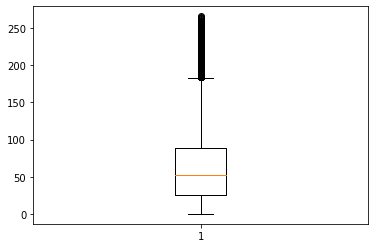

In [39]:
max_frames = main_df.frame.max() + 1
print(max_frames)
plt.boxplot(main_df.frame)

In [27]:
print(len(pd.unique(main_df.example)))
#print(main_df.head())
yhat = main_df.groupby(by="example").exercise.max()

yhat = pd.get_dummies(yhat)
print(yhat)

214
                          BodyWeightSquats  PushUps
example                                            
BodyWeightSquats_g01_c01                 1        0
BodyWeightSquats_g01_c02                 1        0
BodyWeightSquats_g01_c03                 1        0
BodyWeightSquats_g01_c04                 1        0
BodyWeightSquats_g02_c01                 1        0
...                                    ...      ...
PushUps_g24_c04                          0        1
PushUps_g25_c01                          0        1
PushUps_g25_c02                          0        1
PushUps_g25_c03                          0        1
PushUps_g25_c04                          0        1

[214 rows x 2 columns]


In [55]:
video_frames = []

for video in main_df.groupby(by="example"):
    current = video[1]
    current = current.drop(columns=["exercise","frame","example"])
    current = current.to_numpy()
    #print(current.shape)
    #print(type(current))
    padded = np.ones((max_frames, 132))
    padded *= -2
    padded[0:current.shape[0],:] = current
    video_frames.append(padded)

x = np.stack(video_frames, axis=0)
print(x.shape)
#214 is the video count
#267 is max length of video
#132 is the number of features per frame

(214, 267, 132)


In [61]:
model = Sequential()
model.add(LSTM(128))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer="adam", loss="CategoricalCrossentropy")


model.fit(x, yhat)
model.summary()

7/7 [==============================] - 3s 132ms/step - loss: nan
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               133632    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 133,890
Trainable params: 133,890
Non-trainable params: 0
_________________________________________________________________
